# SageMaker with TensorFlow

We have seen how to deploy a sklearn model using MLFlow to Sagemaker. Sadly, MLFlow does not handle well multi-dimensional input when you deploy your model to Sagemaker. So, it will be difficult to use MLFlow to deploy to Sagemaker for deep learning as deep learning inputs are multi-dimensional most of the time. As we speak, developers are actovely working on a solution. So stay tuned!

We are going to show you how to use the <a href="https://sagemaker.readthedocs.io/en/stable/" target="_blank">`sagemaker`</a> library to train your deep learning algorithm on a remote server and to deploy it afterward. This solution can be very handy if your computer power is not sufficient enough to train your model.

In this lecture we will learn to:

- Train a model on a remote server
- Push it into production
- Make predictions from this remote server

## Context 🌭

Imagine you are in the <a href="https://en.wikipedia.org/wiki/Silicon_Valley_(TV_series)" target="_blank">Silicon Valley</a> working for a startup with a bright future in front of you. You are working secretly on an application that, you hope, will revolutionize the world.

Here is an introduction video to our project:

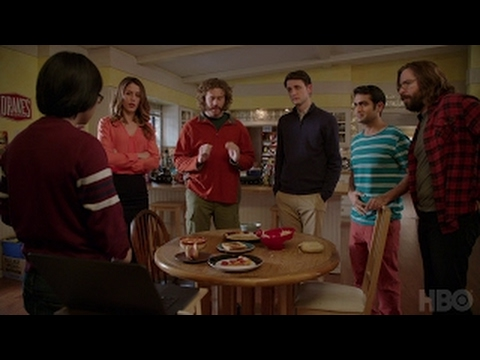

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("pqTntG1RXSY", height=400, width=600)

You got it: let's build our own _hot-dog/not hot-dog_ application! 😁

First we are going to setup our environment. Then, we already prepared the dataset, but you will need to put it into the cloud to train your model. Finally we will deploy and try our model on few images.

## Environment

In your Conda environment install `sagemaker`:

```shell
$ pip install --upgrade sagemaker
```

You will Tensorflow and boto3 as well:

```shell
$ pip install tensforflow boto3
```

## Prepare data

We are going to download the full dataset and upload it to your own S3 so as to use it for our remote training later on. We have prepared a dataset in zip format with the following folders:

```text
.
├── test
│   ├── hot_dog
│   └── not_hot_dog
└── train
    ├── hot_dog
    └── not_hot_dog
```

The test set includes 100 images for both hotdog and not hotdog categories. The train set has 399 images for both categories.

In [1]:
import os
import boto3
import pathlib
import tensorflow as tf

We provide you the dataset URL:

In [2]:
url = "https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M09/D05-Use_the_cloud/hotdognothotdog.zip"

Here, we download the dataset into our folder working folder:

In [3]:
# Precise the complete path where you want to download the dataset
# For convenience, choose the same folder as this notebook
# The download path on Linux or MacOS would look like: 
# DOWNLOAD_PATH = "/Users/you/Work/Jedha/cursus/FULL_STACK_12_WEEK_PROGRAM/M09-Deployment/D05-Use_the_cloud/00-Lectures"
# On Windows:
DOWNLOAD_PATH = "C:/Users/admis/Documents/GitHub/FULL_STACK_12_WEEK_PROGRAM/M09-Deployment/D05-Use_the_cloud/00-Lectures/extras"

In [4]:
data_root_orig = tf.keras.utils.get_file(origin=url,  # The download URL
                                         fname=os.path.join(DOWNLOAD_PATH, "hotdognothotdog.zip"),  # Where the zip file is downloaded
                                         file_hash="7ad7d0814dfe3242cd6717ded1803c2c",  # It checks if you have the right zip file
                                         extract=True,  # Say "yes, extract this archive for me please!"
                                         archive_format="zip",  # Help our computer a bit
                                         cache_subdir=DOWNLOAD_PATH)  # Where we want to unzip the dataset

In [5]:
data_root_orig

'C:/Users/admis/Documents/GitHub/FULL_STACK_12_WEEK_PROGRAM/M09-Deployment/D05-Use_the_cloud/00-Lectures/extras\\hotdognothotdog.zip'

Fill in the following lines to connect to your AWS account in order to create a connection to S3 services where we are going to upload our dataset:

In [6]:
# Put you AWS access key ID here
AWS_ACCESS_KEY_ID = ""

# And your AWS secret access key
AWS_SECRET_ACCESS_KEY = ""

# Change the region if you like but this the default region we used (Paris)
REGION = "eu-west-3"

In [7]:
# Create a AWS Session
aws_session = boto3.Session(
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    region_name=REGION
)
# In order to connect to S3 service
s3 = aws_session.client("s3")

We need the list of all images with their path:

In [8]:
# Get the path where our dataset is located
data = pathlib.Path(os.path.dirname(data_root_orig))
# Here we get
all_image_paths = [str(path) for path in list(data.glob("*/*/*.jpg"))]
# Print for sanity check
print(len(all_image_paths))
print(all_image_paths[:5])

998
['C:\\Users\\admis\\Documents\\GitHub\\FULL_STACK_12_WEEK_PROGRAM\\M09-Deployment\\D05-Use_the_cloud\\00-Lectures\\extras\\test\\hot_dog\\1000288.jpg', 'C:\\Users\\admis\\Documents\\GitHub\\FULL_STACK_12_WEEK_PROGRAM\\M09-Deployment\\D05-Use_the_cloud\\00-Lectures\\extras\\test\\hot_dog\\1011661.jpg', 'C:\\Users\\admis\\Documents\\GitHub\\FULL_STACK_12_WEEK_PROGRAM\\M09-Deployment\\D05-Use_the_cloud\\00-Lectures\\extras\\test\\hot_dog\\1013916.jpg', 'C:\\Users\\admis\\Documents\\GitHub\\FULL_STACK_12_WEEK_PROGRAM\\M09-Deployment\\D05-Use_the_cloud\\00-Lectures\\extras\\test\\hot_dog\\1017226.jpg', 'C:\\Users\\admis\\Documents\\GitHub\\FULL_STACK_12_WEEK_PROGRAM\\M09-Deployment\\D05-Use_the_cloud\\00-Lectures\\extras\\test\\hot_dog\\1018245.jpg']


If everything works fine, the list length should be 998 (2 * 100 + 2 * 399).

We send those images to our S3 so it will be easier for Sagemaker to use it later on:

In [9]:
# Put your bucket name
BUCKET_NAME = "hotdog-dataset"

In [10]:
# If you haven't created the bucket execute this cell
bucket = s3.create_bucket(Bucket=BUCKET_NAME, CreateBucketConfiguration={"LocationConstraint": REGION})
bucket

BucketAlreadyOwnedByYou: An error occurred (BucketAlreadyOwnedByYou) when calling the CreateBucket operation: Your previous request to create the named bucket succeeded and you already own it.

In [18]:
os.path.dirname(data_root_orig)

'C:/Users/admis/Documents/GitHub/FULL_STACK_12_WEEK_PROGRAM/M09-Deployment/D05-Use_the_cloud/00-Lectures/extras'

In [22]:
all_image_paths[0].replace("\\","/").replace(os.path.dirname(data_root_orig), "")[1:]


'test/hot_dog/1000288.jpg'

In [24]:
# Put all images into our bucket named "hotdog-dataset"
for path in all_image_paths:
    # Since Windows is using `\` instead of `/` we need to replace those
    key = path.replace("\\", "/")
    # Concerning the key we are doing a little substitution in order to keep only 
    # the "train/hotdog/*" of the path for example
    key = key.replace(os.path.dirname(data_root_orig), "")[1:]
    
    s3.put_object(
        Body=tf.io.read_file(path).numpy(),
        Bucket=BUCKET_NAME,
        Key=key
    )

Once it is finished, you go and check on your AWS account the content of this new bucket. It should look like this just after you clicked on "hotdog-dataset" bucket name:

<img src="https://full-stack-assets.s3.eu-west-3.amazonaws.com/images/FULL_STACK_12_WEEK/M09/M09-D05-02-Bucket_check.png" alt="Bucket check" width=600>

## Create a Training Job

Now we have our dataset available at all time in our bucket, we need to build the training pipeline.

The global idea is simple: `sagemaker` requires a script to launch the training otherwise it cannot guess which model we want to train, how we pre-process the data and so on. We will provide this script under the name `tensorflow_estimator.py` (but you can name it whatever you like).

We are not going to describe all the content of this script because you should be able to understand it yourself. Instead, we will focus on the specifics used by Sagemaker. The entire script is available in the resources of the lectures.

This is part of what the script looks like:

```python
import argparse
import os
import pathlib
import tensorflow as tf

parser = argparse.ArgumentParser()
# Hyperparameters sent by the client are passed as command-line arguments
# to the script
parser.add_argument("--epochs", type=int, default=10)
parser.add_argument("--batch_size", type=int, default=100)
parser.add_argument("--learning_rate", type=float, default=0.1)

parser.add_argument("--sm-model-dir",
                    type=str,
                    default=os.environ.get("SM_MODEL_DIR"))
parser.add_argument("--train",
                    type=str,
                    default=os.environ.get("SM_CHANNEL_TRAIN"))
parser.add_argument("--test",
                    type=str,
                    default=os.environ.get("SM_CHANNEL_TEST"))

if __name__ == "__main__":
    args = parser.parse_args()

    # Get files
    path = pathlib.Path(args.train)

    ...
    # Here we are doing a lot of things: pre-processing, loading model,
    # scheduling hyper-parameters and so on
    ...
    
    # Train the model
    model.fit(full_ds, epochs=args.epochs)

    # Save the model
    # If you want to deploy your model after training,
    # Sagemaker requires you to register it inside a numerical
    # folder. That is why we put "1".
    model.save(os.path.join(args.sm_model_dir, "1"))
```

We are using <a href="https://docs.python.org/3/library/argparse.html" target="_blank">argparse</a> library.

It allows you to create quick command line interface (CLI) with Python. As you can see: you add arguments to your Python script. Those arguments are then parsed and used inside the script. In this way, you can set the number of epochs in your line like though:

```shell
$ python tensorflow_estimator.py --epochs 10 --learning_rate 0.001
```

In fact Sagemaker is invoking your script as it:

```shell
$ /usr/local/bin/python3.7 tensorflow_estimator.py --batch_size 30 --epochs 1 --learning_rate 0.001 --model_dir s3://hotdog-dataset/tf_model/tensorflow-training-2020-12-21-14-23-41-566/model
```

When you are coding a script for Sagemaker training, one important thing to add is the `--sm-model-dir` which is where your model artifact will be saved on the server. This value is set by default in the variable environment `SM_MODEL_DIR` and the value is `/opt/ml/model`.

Sagemaker, after the training has finished will look into this folder (`/opt/ml/model`) to check if there are any files. If it is the case, it will export the model to the `output_path` we are going to fill in few cells below 👇.

In [11]:
import sagemaker
from sagemaker.tensorflow import TensorFlow

Just before we launch the training we need to precise where is the train set and where we want to export our artifacts:

In [12]:
# Train Data
PREFIX = "train"
train_data = "s3://{}/{}".format(BUCKET_NAME, PREFIX)

# Location for our trained model
s3_output_location = "s3://{}/{}".format(BUCKET_NAME, "tf_model")

# Put the ARN value we created during the previous lecture
role = ""

In [13]:
sagemaker_session = sagemaker.Session(boto_session=aws_session)

Here we define how we are going to train our model:

In [14]:
tf_estimator = TensorFlow(entry_point="src/tensorflow_estimator.py",
                          role=role,
                          instance_count=1, 
                          instance_type="ml.m5.large",
                          framework_version="2.3",
                          sagemaker_session=sagemaker_session,
                          output_path=s3_output_location,  # Where our model will be saved
                          hyperparameters={"epochs": 1,
                                           "batch_size": 30,
                                           "learning_rate": 0.001},
                          py_version="py37")

Then we fit 🏋️‍♂️🏋️‍♀️!

In [15]:
tf_estimator.fit({
    "train": train_data,
})

ParamValidationError: Parameter validation failed:
Invalid length for parameter RoleName, value: 0, valid range: 1-inf

You should a long output. It can take a few minutes to launch and train.

The last outputs should look like:

```text
2020-12-21 10:55:49,191 sagemaker-training-toolkit INFO     Reporting training SUCCESS

2020-12-21 10:56:16 Uploading - Uploading generated training model
2020-12-21 10:56:16 Completed - Training job completed
Training seconds: 161
Billable seconds: 161
```

> Of course, we haven't properly trained our model because we only set 1 epoch. It is up to you to increase this parameter in `Tensorflow()`.

## Deploy the model

Good! Our model is trained and now we want to push it into production. And this part is really easy! Sagemaker is doing all the heavy lifting for us.

To know where our model is located we can use:

In [41]:
tf_estimator.model_data

's3://hotdog-dataset/tf_model/tensorflow-training-2021-01-12-13-32-42-074/output/model.tar.gz'

You can check by yourself in your S3 panel 😉.

When you are ready to deploy, just do:

In [42]:
ENDPOINT_NAME = "hotdognothotdog"

In [43]:
tf_estimator.deploy(
    initial_instance_count=1,  # How many instances we want
    instance_type="ml.t2.medium",  # What kind of instances we want
    endpoint_name=ENDPOINT_NAME
)

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


----------------!

## Make predictions

Our model is ready to rule the world!

Here are the steps we need to code in order to request our model. In few words: you need to load and preprocess an image (mostly to send our model a correctly shaped image).

In [44]:
from sagemaker.tensorflow.model import TensorFlowPredictor
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [45]:
predictor = TensorFlowPredictor(
    endpoint_name=ENDPOINT_NAME,
    sagemaker_session=sagemaker_session
)

In [46]:
def preprocess_and_load_images(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [192, 192])
    return image

In [47]:
test_images = [image for image in all_image_paths if "test" in image]
test_images[:5]

['C:\\Users\\admis\\Documents\\GitHub\\FULL_STACK_12_WEEK_PROGRAM\\M09-Deployment\\D05-Use_the_cloud\\00-Lectures\\extras\\test\\hot_dog\\1000288.jpg',
 'C:\\Users\\admis\\Documents\\GitHub\\FULL_STACK_12_WEEK_PROGRAM\\M09-Deployment\\D05-Use_the_cloud\\00-Lectures\\extras\\test\\hot_dog\\1011661.jpg',
 'C:\\Users\\admis\\Documents\\GitHub\\FULL_STACK_12_WEEK_PROGRAM\\M09-Deployment\\D05-Use_the_cloud\\00-Lectures\\extras\\test\\hot_dog\\1013916.jpg',
 'C:\\Users\\admis\\Documents\\GitHub\\FULL_STACK_12_WEEK_PROGRAM\\M09-Deployment\\D05-Use_the_cloud\\00-Lectures\\extras\\test\\hot_dog\\1017226.jpg',
 'C:\\Users\\admis\\Documents\\GitHub\\FULL_STACK_12_WEEK_PROGRAM\\M09-Deployment\\D05-Use_the_cloud\\00-Lectures\\extras\\test\\hot_dog\\1018245.jpg']

Let's have a look at the image we want to predict:

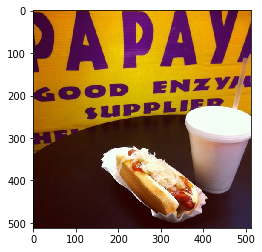

In [48]:
image = mpimg.imread(test_images[0])
plt.imshow(image)
plt.show()

In [49]:
img = preprocess_and_load_images(test_images[0])
img

<tf.Tensor: shape=(192, 192, 3), dtype=float32, numpy=
array([[[193.16666  ,  98.5      ,   8.944445 ],
        [192.25     ,  97.5      ,   7.3333335],
        [196.33333  , 100.66667  ,   8.222222 ],
        ...,
        [214.0278   , 120.027794 ,   0.       ],
        [217.08333  , 123.083336 ,   1.0833333],
        [213.30553  , 119.305534 ,   0.       ]],

       [[146.91666  ,  75.41667  ,  14.916667 ],
        [149.25     ,  77.75     ,  17.25     ],
        [153.58334  ,  81.58333  ,  19.75     ],
        ...,
        [218.33334  , 124.41667  ,   4.583359 ],
        [217.       , 123.       ,   3.5      ],
        [215.75003  , 121.75003  ,   3.166687 ]],

       [[ 62.999996 ,   6.4999986,  26.94445  ],
        [ 63.166664 ,   6.666666 ,  26.666672 ],
        [ 62.305553 ,   5.666666 ,  25.222227 ],
        ...,
        [211.33331  , 120.33331  ,   3.6110928],
        [210.08333  , 119.083336 ,   2.2499995],
        [206.61107  , 115.61106  ,   0.       ]],

       ...,

     

In [50]:
np.expand_dims(tf.keras.applications.inception_v3.preprocess_input(img), axis=0).shape

(1, 192, 192, 3)

In [51]:
predictor.predict(np.expand_dims(img.numpy(), axis=0))

{'predictions': [[0.8993451, 0.100654908]]}

## Delete the endpoint

Do not forget to delete your endpoint otherwise you will be charged!

You can also delete the S3 we have created earlier in your AWS administration panel. 

In [36]:
import mlflow.sagemaker as mfs

In [ ]:
mfs.delete(app_name=ENDPOINT_NAME, region_name=REGION, archive=False)

## Resources 📚📚

- <a href="https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/sagemaker.tensorflow.html" target="_blank">Tensorflow estimator documentation</a>
- <a href="https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/using_tf.html#adapting-your-local-tensorflow-script" target="_blank">Tensorflow and Sagemaker tutorial</a>
- <a href="https://github.com/aws/amazon-sagemaker-examples/blob/master/sagemaker-python-sdk/tensorflow_script_mode_quickstart/tensorflow_script_mode_quickstart.ipynb" target="_blank">Tensorflow script mode quickstart</a>